In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

from cassL import camb_interface as ci

import copy as cp

In [2]:
omega_index = 1 # while we debug, we confine our attention to just one value
omnuh2_float = ci.OMNUH2_FLOATS[omega_index]
omnuh2_str = ci.OMNUH2_STRS[omega_index]

In [3]:
# Axe the 0.01 value since Ariel has not tested that one in the shared results
powernu3 = ci.load_benchmark(
    "power_nu3/Aletheia_powernu3_zorig_nu",
    ["0.0006", "0.0021", "0.0064", "0.0100"] 
)

In [4]:
ci.OMNUH2_FLOATS = ci.OMNUH2_FLOATS[:(len(ci.OMNUH2_FLOATS) - 1)]
ci.OMNUH2_STRS = ci.OMNUH2_STRS[:(len(ci.OMNUH2_STRS) - 1)]

In [5]:
skips_omega = cp.deepcopy(ci.OMNUH2_FLOATS)
skips_omega = np.delete(skips_omega, 1)

In [7]:
def percent_error(trusted, tested):
    return 100 * (tested - trusted) / trusted

In [10]:
# It's a waste of time to consider all of the omegas and snapshots,
# so we're making heavy use of skips.
spectra = ci.boltzmann_battery(ci.OMNUH2_FLOATS,
    skips_omega = skips_omega, skips_model=list(range(2, 9)), skips_snapshot=[1, 2, 3],
    k_points=1000)

In [17]:
i = 5
true_early = powernu3[omnuh2_str][i][0]
true_late = powernu3[omnuh2_str][i][4]
# The following construction makes indexing a little easier later.
true = [true_early, None, None, None, true_late]

#LCDM = np.load('../../CAKE21/matteos_spectra/LCDM.npy', allow_pickle=True)[0]
#nuCDM = np.load('../../CAKE21/matteos_spectra/nuCDM.npy', allow_pickle=True)[0]

LCDM = np.load('../../CAKE21/matteos_spectra/LCDM_tiny.npy', allow_pickle=True).item()
nuCDM = np.load('../../CAKE21/matteos_spectra/nuCDM_tiny.npy', allow_pickle=True).item()

mimsim = np.load('../../CAKE21/matteos_spectra/mimsims.npy', allow_pickle=True).item()

In [12]:
def model_i_ends(i):
    zs = ci.parse_redshifts(i)
    return [max(zs), min(zs)]

modeli = 0
model = ci.specify_neutrino_mass(ci.cosm.iloc[modeli],
    omnuh2_float, 1)
model["omch2"] -= model["omnuh2"]

MEMNeC = ci.specify_neutrino_mass(ci.cosm.iloc[modeli], 0, 0)

Lukas_LCDM = ci.evaluate_cosmology(
    model, redshifts=model_i_ends(modeli))
Lukas_nuCDM = ci.evaluate_cosmology(
    MEMNeC, redshifts=model_i_ends(modeli))
Lukas_h = ci.cosm.iloc[modeli]['h']

In [13]:
p_interpolator = ci.cosmology_to_PK_interpolator(
    model, redshifts=np.flip(np.linspace(0, 3, 150)),
    fancy_neutrinos=False, kmax=10, hubble_units=False)
p_MEMNeC_interpolator = ci.cosmology_to_PK_interpolator(
    MEMNeC, redshifts=np.flip(np.linspace(0, 3, 150)),
    fancy_neutrinos=False, kmax=10, hubble_units=False)

[2.   1.   0.57 0.3  0.  ]


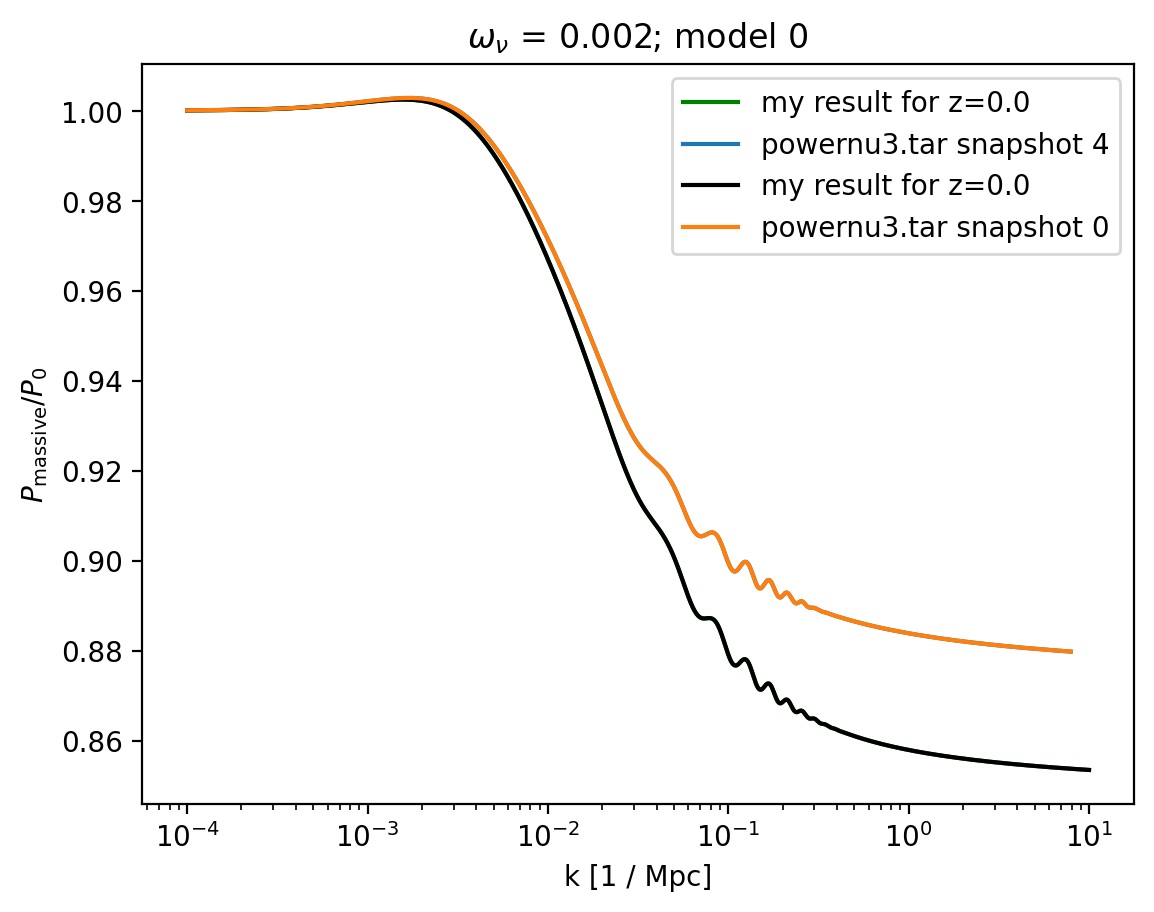

In [14]:
# best case seems to be i = 0
# worst case seems to be i = 1
i=0
on_accessor = ci.OMNUH2_FLOATS[1]
h = ci.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)

print(z_list)
spectrum = spectra[on_accessor][i][j]

plt.plot(spectrum["k"], spectrum["P_nu"] / spectrum["P_no"], c=ci.colors[i],
    label="my result for z=" + str(z_list[j]))
plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="powernu3.tar snapshot 4")
spectrum = spectra[on_accessor][i][j]

plt.plot(spectrum["k"], spectrum["P_nu"] / spectrum["P_no"], c="black",
    label="my result for z=" + str(z_list[j]))
plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="powernu3.tar snapshot 0")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del h, j, z_list, spectrum, on_accessor

[2.   1.   0.57 0.3  0.  ]


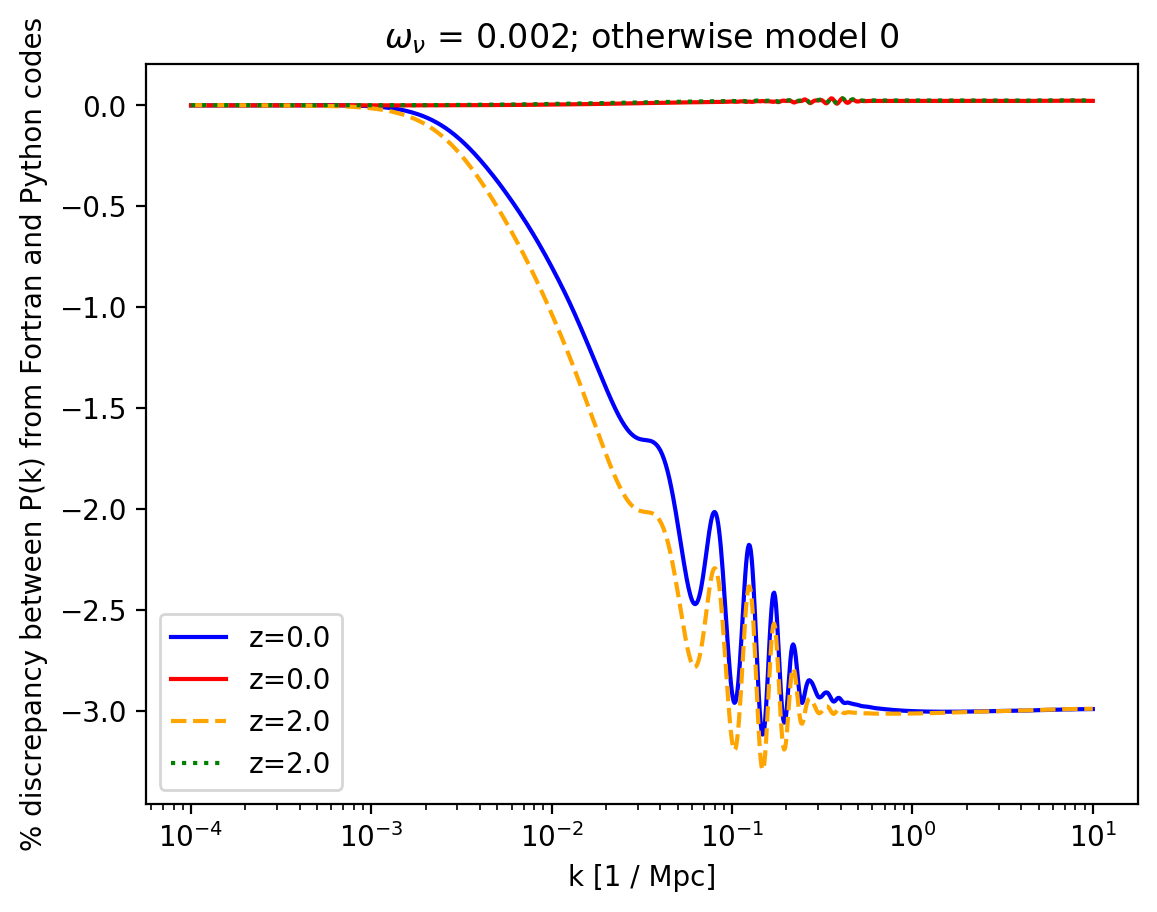

In [19]:
# best case seems to be i = 0
# worst case seems to be i = 1
i=0
on_accessor = ci.OMNUH2_FLOATS[1]
h = ci.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)

print(z_list)

spectrum = spectra[on_accessor][i][j]
x_direct = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true3[j]["ratio"]

my_Pk = p_interpolator.P(z_list[j], true[j]["k"])
my_MEMNeC_Pk = p_MEMNeC_interpolator.P(z_list[j], true[j]["k"])
x_interpolator = my_Pk / my_MEMNeC_Pk

plt.plot(spectrum["k"], percent_error(x_Ariel, x_direct), c="blue",
    label="z=" + str(z_list[j]))
plt.plot(spectrum["k"], percent_error(x_Ariel, x_interpolator), c="red",
    label="z=" + str(z_list[j]))

j = 0
spectrum = spectra[on_accessor][i][j]
x_direct = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true3[j]["ratio"]

my_Pk = p_interpolator.P(z_list[j], true[j]["k"])
my_MEMNeC_Pk = p_MEMNeC_interpolator.P(z_list[j], true[j]["k"])
x_interpolator = my_Pk / my_MEMNeC_Pk

plt.plot(spectrum["k"], percent_error(x_Ariel, x_direct), c="orange",
    label="z=" + str(z_list[j]), linestyle="dashed")
plt.plot(spectrum["k"], percent_error(x_Ariel, x_interpolator), c="green",
    label="z=" + str(z_list[j]), linestyle="dotted")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"% discrepancy between P(k) from Fortran and Python codes")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; otherwise model 0")
plt.legend()

plt.savefig("../plots/camb_interface/accuracy/model0.png")
# This protects other cells by avoiding unintended reuse
del h, j, z_list, spectrum, on_accessor